# Information Value

Vamos a testear Information Value definido por Zanette & Montemurro.

La primer versión que veremos es sobre un texto shuffleado. Esta es la que, en teoría, anda bien (o al menos da los mismos resultados que el paper!).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys

sys.path.append("..")

from __future__ import division, print_function
import pandas as pd
import numpy as np
import nltk
import math
from nltk.corpus import stopwords, gutenberg 
from iv_helpers import get_moby_dick_tokens

md_tokens = get_moby_dick_tokens()

fd = nltk.FreqDist(md_tokens)

In [2]:
from scipy.stats import entropy

window_size = 5000

def ocurrence_dataframe(tokenized_text, window_size):
    """
    Construye una matriz de ocurrencias dado un tamaño de ventana
    """
    freq = {}
    """
    N = Largo del texto
    P = Cantidad de ventanas
    """
    N = len(tokenized_text)
    P = int(math.ceil(N / window_size))

    for i in range(0, P):
        """
        Para cada ventana: hago un Fdist de la ventana, y lo sumo a las palabras que ya tenga
        """
        lower_bound, upper_bound = window_size * i, min(window_size* (i+1), N) 
        window = tokenized_text[lower_bound:upper_bound]
        window_fdist = nltk.FreqDist(window)

        for word in window_fdist:
            if word not in freq:
                freq[word] = [0] * P
                
            freq[word][i] = window_fdist[word]
            
    df = pd.DataFrame.from_dict(freq, orient="index")
    
    df["entropy"] = df.apply(entropy, axis=1, raw=True)
    df["total"] = df[range(P)].apply(sum, axis=1, raw=True)
    df["freq"] = df["total"] / len(tokenized_text)
    df["not_stop_word"] = df.index.map(lambda w: w not in stopwords.words('english'))
    
    return df

occurrence_df = ocurrence_dataframe(md_tokens, window_size)

occurrence_df.sort_values(by="entropy", inplace=True)

# Information Value

Calculemos Information Value con un texto randomizado

In [3]:
import random

# Shuffleo Texto
shuffled_text = random.shuffle(md_tokens)
shuffled_df = ocurrence_dataframe(md_tokens, window_size)
#
occurrence_df["shuffled_entropy"] = shuffled_df["entropy"]
occurrence_df["information_value"] = occurrence_df.freq * (occurrence_df.shuffled_entropy - occurrence_df.entropy)

occurrence_df.sort_values("information_value", ascending=False, inplace=True)
occurrence_df.iloc[:40][occurrence_df.columns.difference(range(42))]

,entropy,freq,information_value,not_stop_word,shuffled_entropy,total
whale,3.437954,0.005854,0.001643,True,3.718585,1226
ahab,3.129364,0.002440,0.001406,True,3.705411,511
queequeg,2.680595,0.001203,0.001173,True,3.655074,252
is,3.592272,0.008237,0.001101,False,3.725944,1725
ye,3.230246,0.002254,0.001036,True,3.689770,472
you,3.480810,0.004269,0.000950,False,3.703450,894
thou,2.934329,0.001294,0.000933,True,3.655085,271
me,3.403535,0.003022,0.000900,False,3.701177,633
bildad,1.106762,0.000363,0.000843,True,3.429697,76
jonah,1.433252,0.000406,0.000824,True,3.463168,85


# Shuffle simulado

En vez de hacer todo el shuffle, hago uno que simulo yo: simulo repartir, para una palabra w, sus n apariciones en la cantidad de partes en las cuáles separo mi texto.

Recordando un poco de combinatoria, esto es como buscar alguna de las combinaciones de bosones en cajitas. Lo podemos modelar con un string de la forma...

ooooooo||||||||||||

con tantas "o" como bolitas, y "|" como cajitas-1. 

La función que muestro a continuación simula una tirada de esto

In [7]:
# %load -s random_balls_in_bins ../iv_helpers.py
def random_balls_in_bins(balls, bins):
    """Return a list of <bins> integers that sum <balls>.

    We can think this as a problem of bosons:

    We have to distribute balls in bins. To model this, we use a shuffle of

    'o' * balls + '|' * (bins-1)

    This results in a string of the form oo|ooo|oo where we leave the last '|' fixed

    Parameters:
    ----------

    balls: int > 0
        number of balls to distribute
    bins: int > 0
        number of bins

    Returns
    -------

    A list of <bins> integers that sum <balls>
    """
    balls_and_bins = list('o' * balls + '|' * (bins - 1))
    random.shuffle(balls_and_bins)

    bins = []
    current = 0

    for e in balls_and_bins:
        if e == 'o':
            current += 1
        elif e == '|':
            bins.append(current)
            current = 0

    bins.append(current)

    return bins


Calculemos una entropía shuffleada con este algoritmo

In [ ]:
# %load -s simulated_shuffled_entropy ../iv_helpers.py
def simulated_shuffled_entropy(word_series, no_tokens, window_size):
    """Calculate simulated-shuffled entropy.

    Parameters
    ----------

    word_series: pandas.Series
        row of a dataframe built with occurrence_dataframe function
    no_tokens: int
        Number of tokens (N) in text
    window_size: int
        Number of tokens per window
    hypergeom: function with parameters k, M, N, n
        Function calculating the mass function of a Hypergeometric with parameters M, N, n
    """
    p = int(math.ceil(no_tokens / window_size))
    n = word_series.total

    shuffled_words = random_balls_in_bins(balls=n, bins=p)

    return entropy(shuffled_words)


In [10]:
from iv_helpers import simulated_shuffled_entropy

fn = lambda ws: simulated_shuffled_entropy(ws, len(md_tokens), window_size)
occurrence_df["sim_shuffled_entropy"] = occurrence_df.apply(fn, axis=1)

In [11]:
occurrence_df["sim_information_value"] = occurrence_df.freq *\
    (occurrence_df.sim_shuffled_entropy - occurrence_df.entropy)

occurrence_df.sort_values("sim_information_value", ascending=False, inplace=True)
occurrence_df.iloc[:40][occurrence_df.columns.difference(range(42))]

,entropy,freq,information_value,not_stop_word,shuffled_entropy,sim_information_value,sim_shuffled_entropy,total
queequeg,2.680595,0.001203,0.001173,True,3.655074,0.000842,3.380513,252
bildad,1.106762,0.000363,0.000843,True,3.429697,0.000682,2.986035,76
peleg,1.271157,0.000353,0.000753,True,3.401066,0.000632,3.060687,74
jonah,1.433252,0.000406,0.000824,True,3.463168,0.000596,2.902316,85
stubb,2.959690,0.001227,0.000812,True,3.621396,0.000523,3.385517,257
ahab,3.129364,0.002440,0.001406,True,3.705411,0.000521,3.342853,511
cook,1.287807,0.000263,0.000502,True,3.199011,0.000477,3.102783,55
pip,1.730171,0.000353,0.000620,True,3.485793,0.000455,3.017994,74
steelkilt,0.661563,0.000191,0.000452,True,3.025803,0.000452,3.025803,40
thou,2.934329,0.001294,0.000933,True,3.655085,0.000392,3.237465,271


La tabla da algo distinta... Esto puede ser por varias cosas: el shuffle que estoy haciendo es distinto de un shuffle cualquiera del texto, o bien considerar a la última cajita (potencialmente con menos palabras) cambia la distribución de la entropía shuffleada.

Aún así, la lista parece mantener la gran mayoría de las mismas palabras. Más aún, veo menos "stopwords" que en la lista de Zanette y Montemurro

Veamos qué distribución tienen las diferencias con la del shuffleo común.

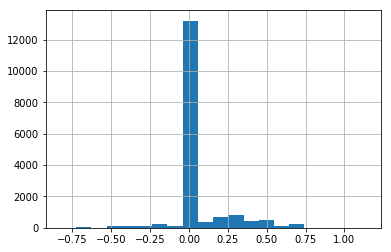

In [13]:
(occurrence_df.shuffled_entropy - occurrence_df.sim_shuffled_entropy).hist(bins=20);